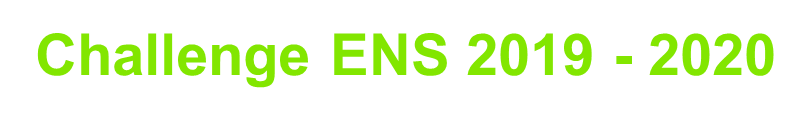
#Defect Prediction on production line Introduction

## Disclaimer

This colabs is my first attempt to implement machine learning tools on a real dataset.

I may not use the state of the art methodology and I'm fine with it as my main purpose is to try, learn an uderstand. Feel free to point out any mistake or inconsistency in my try

## Context

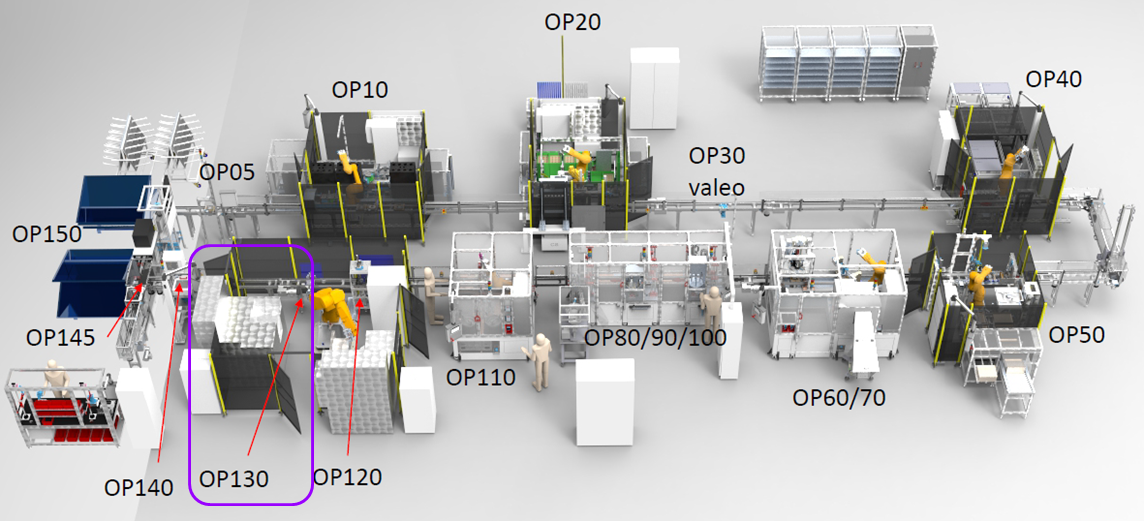



dataset provided by the automotive supplier company VALEO, coming
from a production line, and hosted by the Ecole Normale Superieure
(ENS) Data Challenge

**Production line workstations:**

1. OP70: Screwing
  
  * `OP070_V_1_angle`: Measured angle of the first screwer of the station
  * `OP070_V_2_angle`: Measured angle of the Second screwer of the station
  * `OP070_V_1_torque`: Real value measured of the setting (set torque, gives the angle). Screwer 1 applied torque on the product
  * `OP070_V_2_torque`: Real value measured of the setting (set torque, gives the angle). Screwer 2 applied torque on the product

2. OP090: Ring insertion
  * `OP090_StartLinePeakForce`: Measured force (KISTLER sensor). Start force of one curve applied to insert one ring in product (Point 1)
  * `OP090_SnapRingMidPointForce`: Measured force (KISTLER sensor).
Mid force of one curve applied to insert one ring in product (Point 2)
  * `OP090_SnapRingMidPointForce`: Measured force (KISTLER sensor).
Mid force of one curve applied to insert one ring in product (Point 3)
  * `OP090_SnapRingFinalStroke`: Measured force (KISTLER sensor).
Mid force of one curve applied to insert one ring in product (Point 3)

3. OP100: Cap assembly
  * `OP100_Capuchon_insertion_mesure`: Measured displacement (HEIDENHAIN LINEAR RULE). Displacement measure of one cap inserted in product

4. OP110: Screw M8
  * `OP110_Vissage_M8_torque`:Real value measured of the setting (set torque, gives the angle). Torque applied on the long screw M8
  * `OP110_Vissage_M8_angle`: Angle measured on the product of screw M8

5. OP120: Lapping
  * `OP120_Rodage_U_mesure`: Measure of setting value (set tension, read intensity to facilitate lapping)
  * `OP120_Rodage_I_mesure`:Measured intensity consequent of the tension applied as setting

6. OP130: Performance Test
  * `Binar_OP130_Resultat_Global_v`:Result of the testing benches. Good or Bad according to final testing of power and acoustic characteristics


source: https://bradscholars.brad.ac.uk/bitstream/handle/10454/19037/EDMA-2021_paper_9.pdf?sequence=2&isAllowed=n




## Objectives

Predict defects using non-anonymised features,
without access to final test results, to validate the part status (defective
or not).

##Performance measurement and benchmark

**Metric:** AUROC ( Area Under Receiver Operating Characteristic)

**Classifier:** Bayes classifier

**Result:** 0.675


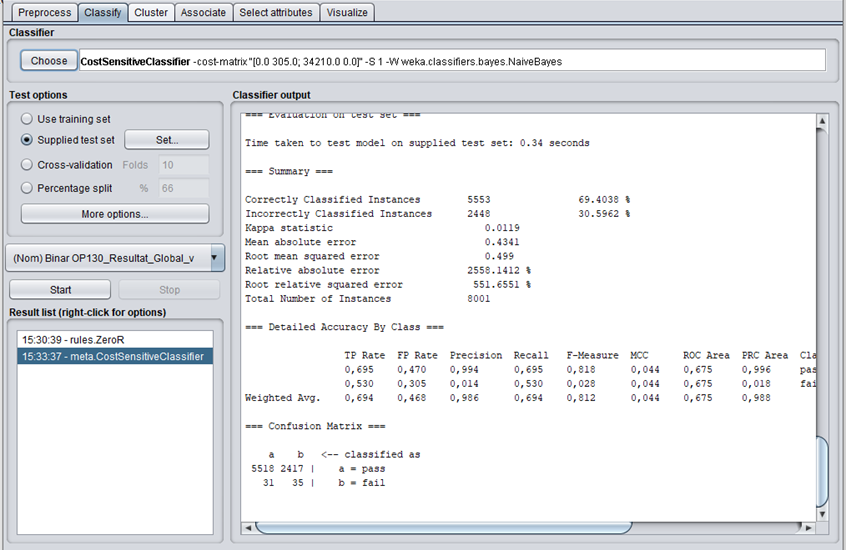

Step1: reproduce this performance with bayes classifier

Step2: improve performance by other ML algorithms

Step3: try Neural Network

# Library & utilities

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
def percentage( X, feature_name, value):
  return len(X[X[feature_name]==value])/len(X)


#Datasets import

In [90]:
# for convenience purpose the data file is stored in my personal onedrive
url='https://github.com/dim2s/SAFI/raw/refs/heads/main/Dataset_pour_workshop.csv'

#this dataframe will contain raw data from valeo
valeo_data=pd.read_csv(url)

#this dataframe will contain all modifications
sandbox_data=valeo_data.copy()

In [57]:
valeo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42516 entries, 0 to 42515
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PROC_TRACEINFO                   42516 non-null  object 
 1   OP070_V_1_angle_value            42516 non-null  float64
 2   OP090_SnapRingPeakForce_value    42516 non-null  float64
 3   OP070_V_2_angle_value            42516 non-null  float64
 4   OP120_Rodage_I_mesure_value      42516 non-null  float64
 5   OP090_SnapRingFinalStroke_value  42516 non-null  float64
 6   OP110_Vissage_M8_torque_value    42516 non-null  float64
 7   OP100_Capuchon_insertion_mesure  19529 non-null  float64
 8   OP120_Rodage_U_mesure_value      42516 non-null  float64
 9   OP070_V_1_torque_value           42516 non-null  float64
 10  OP090_StartLinePeakForce_value   42516 non-null  float64
 11  OP110_Vissage_M8_angle_value     42516 non-null  float64
 12  OP090_SnapRingMidP

In [91]:
percentage(valeo_data, 'Binar_OP130_Resultat_Global_v', 2)

0.00872612663467871

#Data exploration & feature engineering

In [92]:
sandbox_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42516 entries, 0 to 42515
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PROC_TRACEINFO                   42516 non-null  object 
 1   OP070_V_1_angle_value            42516 non-null  float64
 2   OP090_SnapRingPeakForce_value    42516 non-null  float64
 3   OP070_V_2_angle_value            42516 non-null  float64
 4   OP120_Rodage_I_mesure_value      42516 non-null  float64
 5   OP090_SnapRingFinalStroke_value  42516 non-null  float64
 6   OP110_Vissage_M8_torque_value    42516 non-null  float64
 7   OP100_Capuchon_insertion_mesure  19529 non-null  float64
 8   OP120_Rodage_U_mesure_value      42516 non-null  float64
 9   OP070_V_1_torque_value           42516 non-null  float64
 10  OP090_StartLinePeakForce_value   42516 non-null  float64
 11  OP110_Vissage_M8_angle_value     42516 non-null  float64
 12  OP090_SnapRingMidP

## PROC_TRACEINFO feature

In [93]:
len(sandbox_data["PROC_TRACEINFO"].unique())

42516

All entries from "PROC_TRACEINFO" are unique!

In [94]:
print(sandbox_data["PROC_TRACEINFO"].iloc[0])

I-B-XA1207672-190429-00688


Entries from PROC_TRACEINFO are composed from 3 parts:

* I-B-XA1207672 ref of the product
* 190429 date of the operation format (YYMMDD)
* ID of the product increment every 12s

In [95]:
re_patern=r'^([a-zA-Z]{1}-[a-zA-Z]{1}-[a-zA-Z]{2}\d{7})-(\d{2}\d{2}\d{2})-(\d+)$'

sandbox_data[["_reference","_date","_serial"]]=sandbox_data["PROC_TRACEINFO"].str.extract(re_patern)
sandbox_data.head(3)

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar_OP130_Resultat_Global_v,_reference,_date,_serial
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60,1,I-B-XA1207672,190429,00688
1,I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,1,I-B-XA1207672,190828,00973
2,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61,1,I-B-XA1207672,190712,03462


In [96]:
sandbox_data["_reference"].value_counts()

,count
_reference,
I-B-XA1207672,42516


All entries have the same product "I-B-XA1207672" reference.

we won't extract any additional information from this => this feature (*_reference*) can be drop on all rows

In [97]:
sandbox_data['_date']=pd.to_datetime(sandbox_data['_date'], format='%y%m%d')

In [98]:
sandbox_data['_day']=sandbox_data['_date'].dt.day_of_week
sandbox_data['_month']=sandbox_data['_date'].dt.month
sandbox_data.head()

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar_OP130_Resultat_Global_v,_reference,_date,_serial,_day,_month
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60,1,I-B-XA1207672,2019-04-29,00688,0,4
1,I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,1,I-B-XA1207672,2019-08-28,00973,2,8
2,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61,1,I-B-XA1207672,2019-07-12,03462,4,7
3,I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61,1,I-B-XA1207672,2019-08-03,00051,5,8
4,I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,NaN,11.97,6.62,29.22,33.6,99.19,6.61,1,I-B-XA1207672,2019-05-08,03248,2,5


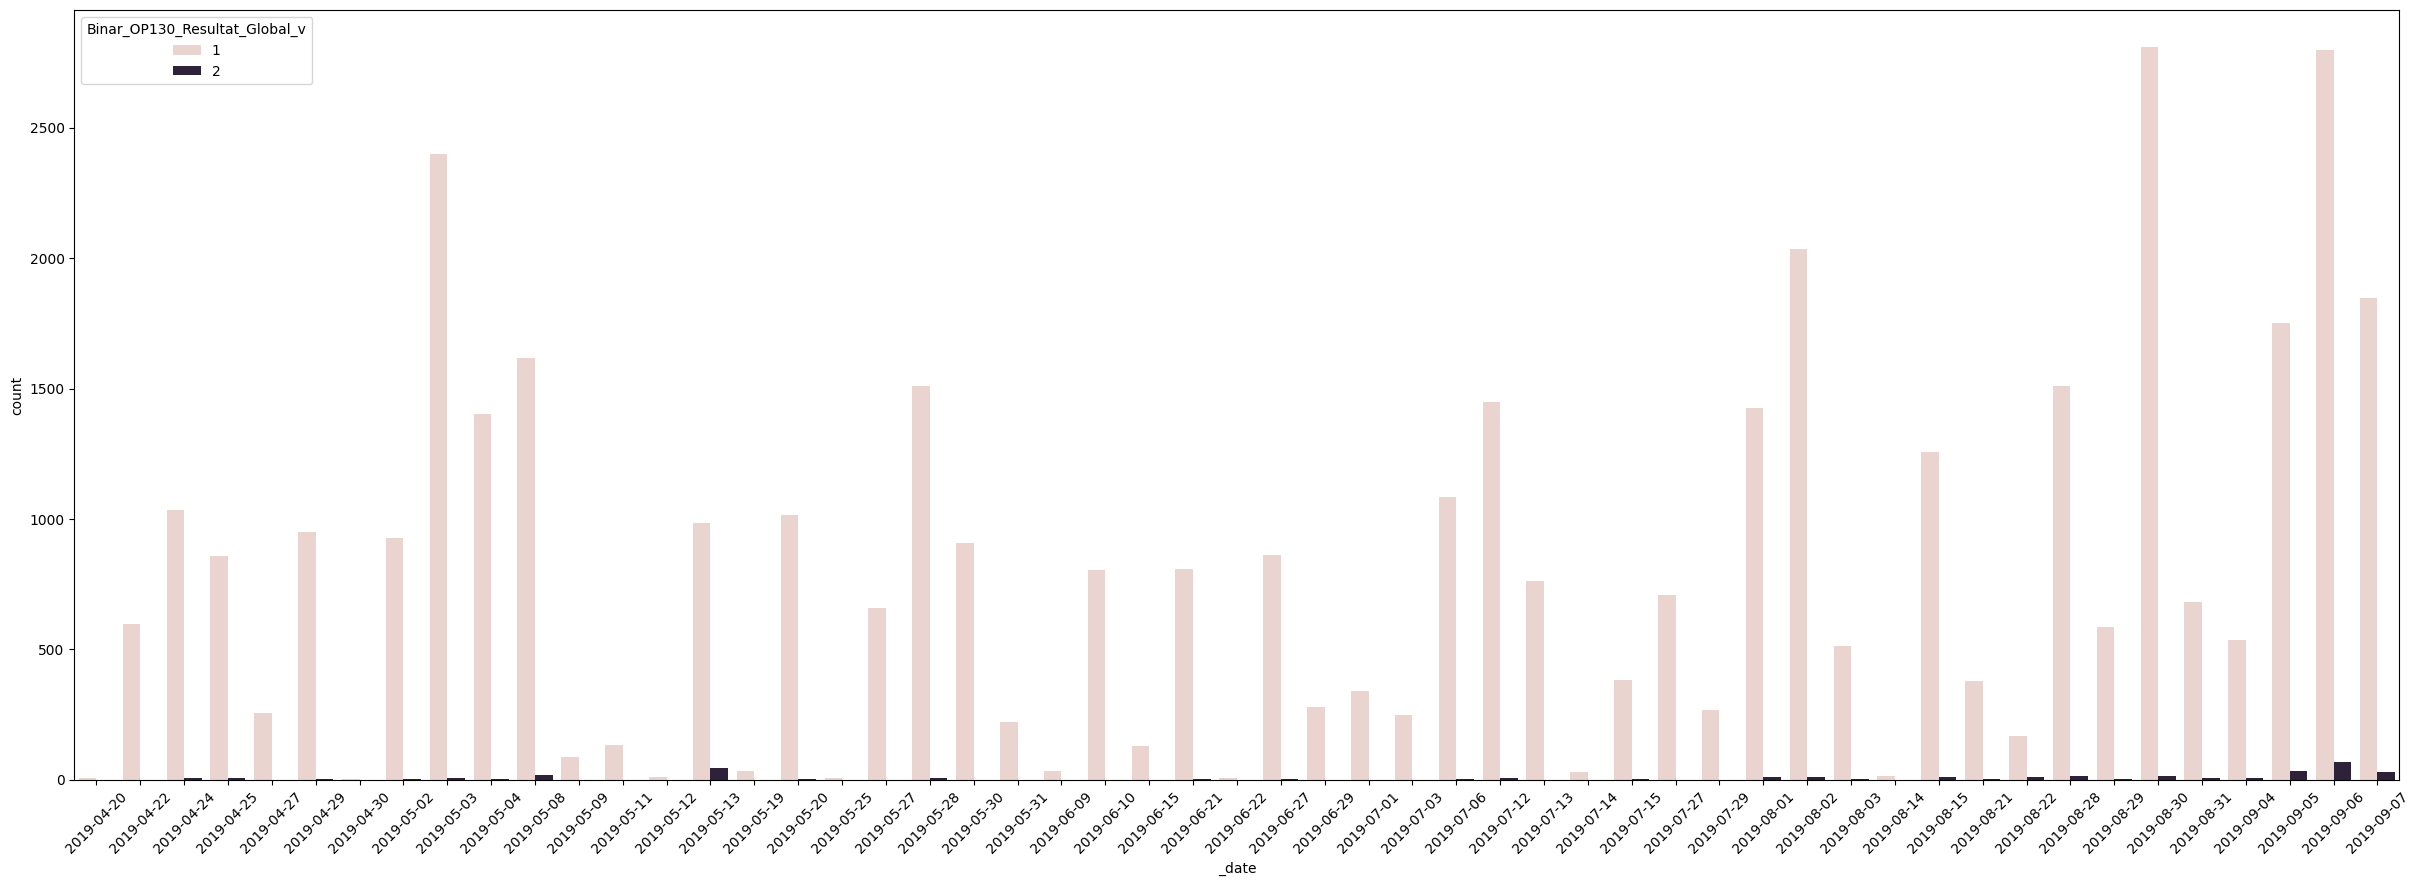

In [99]:
df=sandbox_data[['_date','Binar_OP130_Resultat_Global_v']].sort_values(by='_date')

plt.figure(figsize=(30,10))
sns.countplot(data=df, x='_date', hue='Binar_OP130_Resultat_Global_v')
plt.xticks(rotation=45)

plt.show()

### Is there a special frequency between incident?

In [100]:
ko_events=sandbox_data[sandbox_data['Binar_OP130_Resultat_Global_v']==2][['_date','Binar_OP130_Resultat_Global_v']].sort_values(by='_date')
ko_events_summary=ko_events.groupby('_date').count()

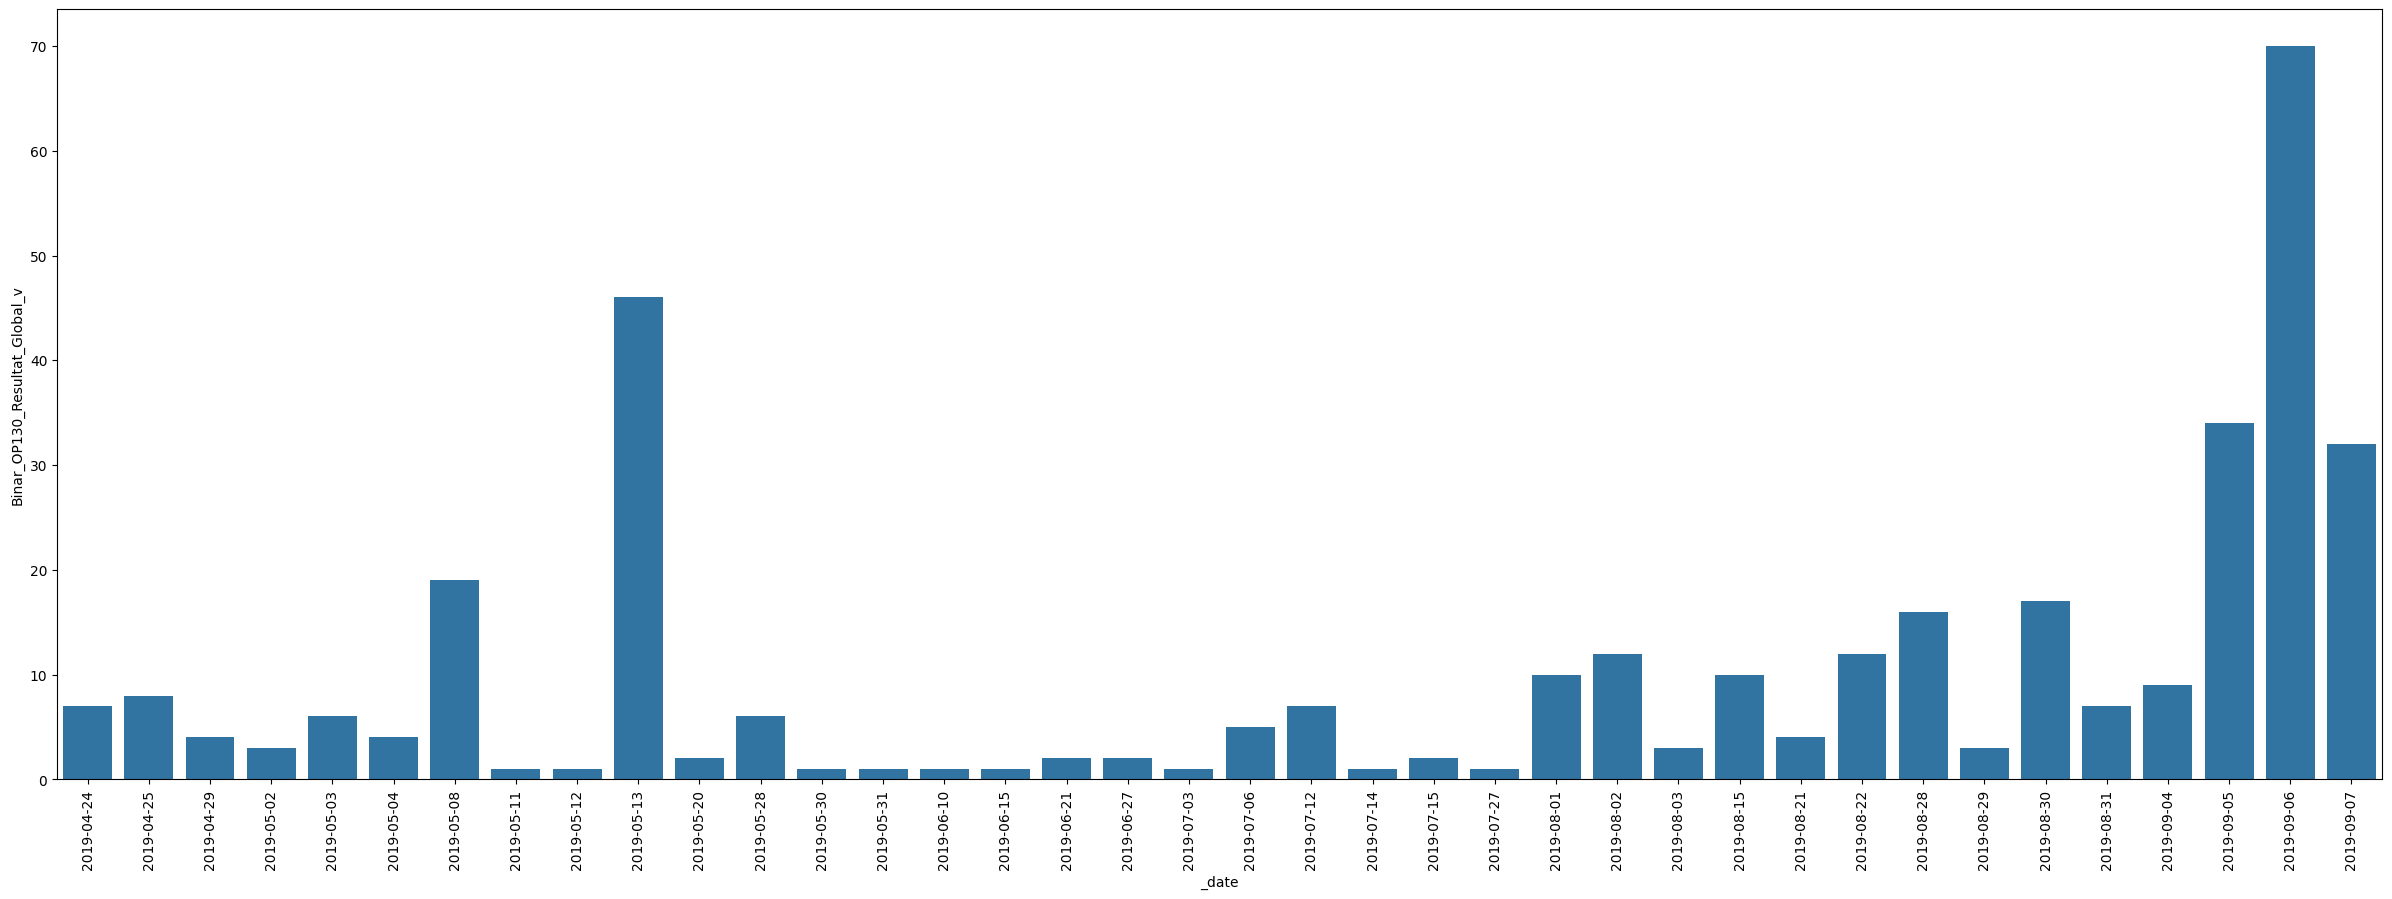

In [101]:
plt.figure(figsize=(30,10))
sns.barplot(data=ko_events_summary, x='_date', y='Binar_OP130_Resultat_Global_v')
plt.xticks(rotation=90)

plt.show()

In [102]:
ko_events

,_date,Binar_OP130_Resultat_Global_v
28579,2019-04-24,2
5153,2019-04-24,2
9106,2019-04-24,2
15683,2019-04-24,2
769,2019-04-24,2
...,...,...
24419,2019-09-07,2
18782,2019-09-07,2
24937,2019-09-07,2
8369,2019-09-07,2


In [103]:
ko_events_summary.sort_values(by='Binar_OP130_Resultat_Global_v', ascending=False).head(7)

,Binar_OP130_Resultat_Global_v
_date,
2019-09-06,70
2019-05-13,46
2019-09-05,34
2019-09-07,32
2019-05-08,19
2019-08-30,17
2019-08-28,16


the number of daily defects is not uniform.

We see a surge in daily defects at two specifics moments:


1.   Between the 2019-09-05 and 2019-09-07
2.   the 2019-05-13

the *'date'* may have some usable informations.
if the sample we use to train the model do not contain these specific dates it will miss almost 50% of the defects


In [104]:
sandbox_data['_reference'].value_counts()

,count
_reference,
I-B-XA1207672,42516


all references are the same: *I-B-XA-1207672* we can drop it

In [105]:
features_to_drop.add('_reference')

the *'_serial'* number is incremented every x seconds so obviously some will have more defect thant others but has the incrementation is perpetual I don't believe we could base our prediction on it => I propose to drop it also

In [106]:
features_to_drop.add('_serial')
features_to_drop

{'Binar_OP130_Resultat_Global_v',
 'PROC_TRACEINFO',
 '_date',
 '_reference',
 '_serial'}

##OP070 station

* OP070_V_1_angle_value            42516 non-null  float64
* OP070_V_2_angle_value            42516 non-null float64       
* OP070_V_1_torque_value           42516 non-null  float64     
  
* OP070_V_2_torque_value           42516 non-null  float64
      

In [107]:
sandbox_data["OP070_V_1_angle_value"].isnull().count()

42516

In [108]:
sandbox_data["OP070_V_1_angle_value"].unique()

array([180.4, 138.7, 180.9, 173.5, 174.5, 158.7, 158.8, 181. , 156.1,
       159.4, 165.9, 168.9, 159.1, 154.1, 142.9, 146.7, 157.4, 173.1,
       144.6, 164.3, 165.5, 171.5, 155. , 127.9, 168.3, 189.3, 150.1,
       177.6, 185. , 172.5, 166.8, 162. , 137.6, 154. , 164.2, 144.2,
       138. , 139.6, 175.7, 138.8, 140.2, 158.2, 166.3, 150.4, 153.8,
       153.7, 150.8, 167.7, 170.8, 176.2, 145.5, 156.3, 131.1, 159.7,
       184.9, 162.2, 138.4, 149.4, 181.9, 135.5, 137. , 183.7, 185.7,
       161.6, 166.5, 165.2, 183.8, 164.1, 159.5, 167.1, 157.1, 137.2,
       190.2, 146.1, 132.2, 144.9, 160.4, 197.7, 163.4, 151.1, 133.7,
       156.4, 147.7, 176.7, 156. , 158.4, 162.3, 151.4, 172. , 135.7,
       157.8, 149.3, 149.2, 156.5, 135.2, 172.6, 164.7, 165.7, 129.6,
       105.1, 192. , 135.9, 151.5, 147.2, 173.3, 145.1, 148.5, 157.2,
       158.6, 174.1, 152.7, 144.1, 153.1, 138.1, 173.8, 149.8, 164.4,
       152.4, 146.6, 141.8, 170.4, 165.3, 139.1, 142.1, 165.8, 165.1,
       162.1, 155.5,

In [109]:
sandbox_data["OP070_V_1_angle_value"].value_counts().head(10)

,count
OP070_V_1_angle_value,
197.8,241
197.9,213
157.1,208
156.0,206
197.7,206
156.1,201
156.3,195
157.2,191
156.9,177


Ce feature ne contient pas de valeurs manquantes

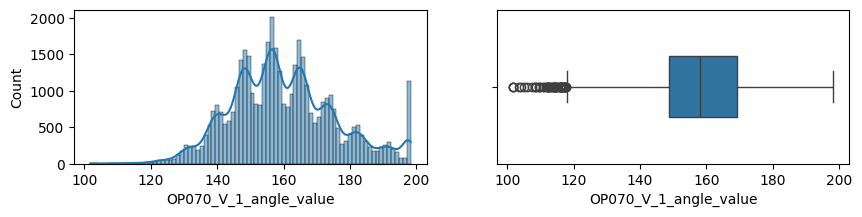

In [110]:
c=sandbox_data["OP070_V_1_angle_value"]
f, axes = plt.subplots(1, 2, figsize=(10, 2))
sns.histplot(c, ax = axes[0], kde=True)
sns.boxplot(x=c, ax = axes[1], width=0.4)
plt.show()

ToDo:
check if outliers contains nok status
check if outliers have an impact on multimodal distribution
creates bins in a new feature

##OP090 station

      
* OP090_SnapRingFinalStroke_value  42516 non-null  float64     
* OP090_SnapRingPeakForce_value    42516 non-null  float64
* OP090_StartLinePeakForce_value   42516 non-null  float64  
* OP090_SnapRingMidPointForce_val  42516 non-null  float64

      
      
      

##OP110 station


* OP110_Vissage_M8_torque_value    42516 non-null  float64       
* OP110_Vissage_M8_angle_value     42516 non-null  float64     


##OP120 station

* OP120_Rodage_U_mesure_value      42516 non-null  float64       
* OP120_Rodage_I_mesure_value      42516 non-null  float64

## OP100 station

OP100 capuchon mesure

##OP130 station

# Machine learning modelisation

## Naive gaussian bayes

In [132]:
features_to_drop

{'Binar_OP130_Resultat_Global_v',
 'OP100_Capuchon_insertion_mesure',
 'PROC_TRACEINFO',
 '_date',
 '_reference',
 '_serial'}

In [142]:
from sklearn.model_selection import train_test_split

#features_to_drop=set()
target='Binar_OP130_Resultat_Global_v'

features_to_drop.add('PROC_TRACEINFO')
#features_to_drop.add('OP100_Capuchon_insertion_mesure')
features_to_drop.add('_reference')
features_to_drop.add('_date')
features_to_drop.add(target)

X=sandbox_data
y=sandbox_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [143]:
print(y_train.value_counts())
print(y_test.value_counts())

Binar_OP130_Resultat_Global_v
1    29494
2      267
Name: count, dtype: int64
Binar_OP130_Resultat_Global_v
1    12651
2      104
Name: count, dtype: int64


In [61]:
percentage(y_train, 'Binar_OP130_Resultat_Global_v', 2)

KeyError: 'Binar_OP130_Resultat_Global_v'

In [144]:
features_to_drop

{'Binar_OP130_Resultat_Global_v',
 'OP100_Capuchon_insertion_mesure',
 'PROC_TRACEINFO',
 '_date',
 '_reference',
 '_serial'}

In [145]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', list(features_to_drop)),
        ('fill_missing_value', SimpleImputer(strategy='mean'), ['OP100_Capuchon_insertion_mesure']),
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [146]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

pipeline = ImbPipeline([
    ('data_preparation', preprocessor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ("model", GaussianNB()  )
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preparation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['_reference', '_serial',
                                                   'PROC_TRACEINFO',
                                                   'Binar_OP130_Resultat_Global_v',
                                                   'OP100_Capuchon_insertion_mesure',
                                                   '_date']),
                                                 ('fill_missing_value',
                                                  SimpleImputer(),
                                                  ['OP100_Capuchon_insertion_mesure'])])),
                ('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model', GaussianNB())])

In [147]:
y_pred=pipeline.predict(X_test)

In [148]:
from sklearn.metrics import roc_auc_score

# Prédiction des probabilités pour l'ensemble de test
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive

# Calcul de l'AUROC
auroc_score = roc_auc_score(y_test, y_prob)

print(f"AUROC: {auroc_score:.4f}")


AUROC: 0.6285


In [149]:
from sklearn.metrics import roc_curve
# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auroc_score = roc_auc_score(y_test, y_prob)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc_score:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de base
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

ValueError: y_true takes value in {1, 2} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [150]:
from sklearn.metrics import classification_report
target_names = ['class OK', 'class KO']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    class OK       0.99      0.70      0.82     12651
    class KO       0.01      0.49      0.03       104

    accuracy                           0.70     12755
   macro avg       0.50      0.60      0.42     12755
weighted avg       0.99      0.70      0.82     12755



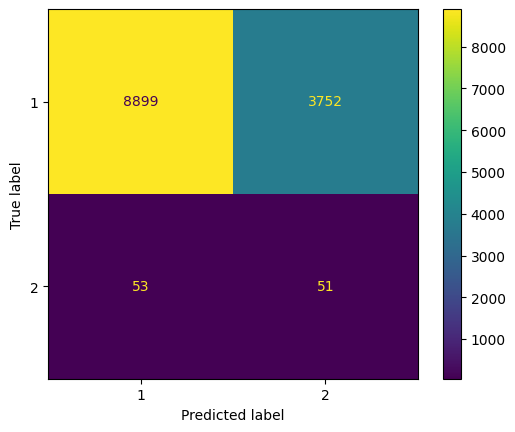

In [151]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# no use for f1 score for the moment
# print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2])
cm_display.plot()